In [26]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            classification_report, roc_curve, auc)
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                             AdaBoostClassifier, VotingClassifier)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import shap
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('ggplot')
%matplotlib inline

shap.initjs()

In [8]:
# Load both datasets
df1 = pd.read_csv(r"C:\Users\Owner\Downloads\archive\PCOS_infertility.csv")
df2 = pd.read_excel(r"C:\Users\Owner\Downloads\archive\PCOS_data_without_infertility.xlsx")

# Display basic info
print("Dataset 1 Shape:", df1.shape)
print("Dataset 2 Shape:", df2.shape)

print("\nDataset 1 Columns:\n", df1.columns.tolist())
print("\nDataset 2 Columns:\n", df2.columns.tolist())

# Check for missing values
print("\nMissing values in Dataset 1:\n", df1.isnull().sum())
print("\nMissing values in Dataset 2:\n", df2.isnull().sum())

# Display first few rows
print("\nDataset 1 Sample:")
display(df1.head())
print("\nDataset 2 Sample:")
display(df2.head())

Dataset 1 Shape: (541, 6)
Dataset 2 Shape: (541, 45)

Dataset 1 Columns:
 ['Sl. No', 'Patient File No.', 'PCOS (Y/N)', '  I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'AMH(ng/mL)']

Dataset 2 Columns:
 ['Sl. No', 'Patient File No.', 'PCOS (Y/N)', ' Age (yrs)', 'Weight (Kg)', 'Height(Cm) ', 'BMI', 'Blood Group', 'Pulse rate(bpm) ', 'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)', 'Cycle length(days)', 'Marraige Status (Yrs)', 'Pregnant(Y/N)', 'No. of aborptions', '  I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'FSH(mIU/mL)', 'LH(mIU/mL)', 'FSH/LH', 'Hip(inch)', 'Waist(inch)', 'Waist:Hip Ratio', 'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)', 'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)', 'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'BP _Systolic (mmHg)', 'BP _Diastolic (mmHg)', 'Follicle No. (L)', 'Follicle No. (R)', 'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)', 'Unnamed: 44

,Sl. No,Patient File No.,PCOS (Y/N),I beta-HCG(mIU/mL),II beta-HCG(mIU/mL),AMH(ng/mL)
0,1,10001,0,1.99,1.99,2.07
1,2,10002,0,60.80,1.99,1.53
2,3,10003,1,494.08,494.08,6.63
3,4,10004,0,1.99,1.99,1.22
4,5,10005,0,801.45,801.45,2.26



Dataset 2 Sample:


,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm),Unnamed: 44
0,1,1,0,28,44.6,152.0,19.3,15,78,22,...,1.0,0,110,80,3,3,18.0,18.0,8.5,NaN
1,2,2,0,36,65.0,161.5,NaN,15,74,20,...,0.0,0,120,70,3,5,15.0,14.0,3.7,NaN
2,3,3,1,33,68.8,165.0,NaN,11,72,18,...,1.0,0,120,80,13,15,18.0,20.0,10.0,NaN
3,4,4,0,37,65.0,148.0,NaN,13,72,20,...,0.0,0,120,70,2,2,15.0,14.0,7.5,NaN
4,5,5,0,25,52.0,161.0,NaN,11,72,18,...,0.0,0,120,80,3,4,16.0,14.0,7.0,NaN


In [19]:
# --- 1. Reload Data and Perform Initial Cleanup ---
# It's best to start fresh to avoid issues from previous cells
df2 = pd.read_excel(r"C:\Users\Owner\Downloads\archive\PCOS_data_without_infertility.xlsx")

# Strip leading/trailing whitespace from all column names
df2.columns = df2.columns.str.strip()

# Drop unnecessary/empty columns
columns_to_drop = ['Sl. No', 'Patient File No.', 'Unnamed: 44']
df2.drop(columns=[col for col in columns_to_drop if col in df2.columns], inplace=True)

# --- 2. Fix Specific Column Data Type Issues ---
# Some columns might be read as 'object' due to stray characters.
# We convert them to numeric, turning any non-numeric values into NaN.
# This prepares them for imputation.
for col in df2.columns:
    df2[col] = pd.to_numeric(df2[col], errors='coerce')

# --- 3. Impute ALL Missing Values ---
# Now, fill any remaining NaNs in any numeric column with the column's median.
# This is the most critical step.
for col in df2.columns:
    if df2[col].isnull().any():
        median_val = df2[col].median()
        df2[col].fillna(median_val, inplace=True)

# --- 4. Verify Imputation Success ---
# This should now print 0.
print(f"Missing values after imputation: {df2.isnull().sum().sum()}")

# --- 5. Convert Data Types (Now that NaNs are gone) ---
# It is now safe to convert float columns that should be integers.
# Your target variable:
df2['PCOS (Y/N)'] = df2['PCOS (Y/N)'].astype(int)

# Known categorical features:
categorical_cols = ['Blood Group', 'Cycle(R/I)', 'Pregnant(Y/N)', 'Weight gain(Y/N)', 
                    'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)', 
                    'Pimples(Y/N)', 'Fast food (Y/N)', 'Reg.Exercise(Y/N)']

for col in categorical_cols:
    if col in df2.columns:
        df2[col] = df2[col].astype(int)

# --- All Done! Let's check the result ---
print("\nData cleaning complete. All columns are numeric and have no missing values.")
df2.info()

Missing values after imputation: 0

Data cleaning complete. All columns are numeric and have no missing values.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PCOS (Y/N)              541 non-null    int32  
 1   Age (yrs)               541 non-null    int64  
 2   Weight (Kg)             541 non-null    float64
 3   Height(Cm)              541 non-null    float64
 4   BMI                     541 non-null    float64
 5   Blood Group             541 non-null    int32  
 6   Pulse rate(bpm)         541 non-null    int64  
 7   RR (breaths/min)        541 non-null    int64  
 8   Hb(g/dl)                541 non-null    float64
 9   Cycle(R/I)              541 non-null    int32  
 10  Cycle length(days)      541 non-null    int64  
 11  Marraige Status (Yrs)   541 non-null    float64
 12  Pregnant(Y/N)           541 non-null

Statistical Summary:


,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
count,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,...,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000
mean,0.327172,31.430684,59.637153,156.484835,23.968577,13.802218,73.247689,19.243993,11.160037,2.560074,...,0.489834,0.515712,0.247689,114.661738,76.927911,6.129390,6.641405,15.018115,15.451701,8.475915
std,0.469615,5.411006,11.028287,6.033545,2.447450,1.840812,4.430285,1.688629,0.866904,0.901950,...,0.500359,0.500216,0.432070,7.384556,5.574112,4.229294,4.436889,3.566839,3.318848,2.165381
min,0.000000,20.000000,31.000000,137.000000,15.100000,11.000000,13.000000,16.000000,8.500000,2.000000,...,0.000000,0.000000,0.000000,12.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,28.000000,52.000000,152.000000,24.000000,13.000000,72.000000,18.000000,10.500000,2.000000,...,0.000000,0.000000,0.000000,110.000000,70.000000,3.000000,3.000000,13.000000,13.000000,7.000000
50%,0.000000,31.000000,59.000000,156.000000,24.000000,14.000000,72.000000,18.000000,11.000000,2.000000,...,0.000000,1.000000,0.000000,110.000000,80.000000,5.000000,6.000000,15.000000,16.000000,8.500000
75%,1.000000,35.000000,65.000000,160.000000,24.000000,15.000000,74.000000,20.000000,11.700000,4.000000,...,1.000000,1.000000,0.000000,120.000000,80.000000,9.000000,10.000000,18.000000,18.000000,9.800000
max,1.000000,48.000000,108.000000,180.000000,38.900000,18.000000,82.000000,28.000000,14.800000,5.000000,...,1.000000,1.000000,1.000000,140.000000,100.000000,22.000000,20.000000,24.000000,24.000000,18.000000


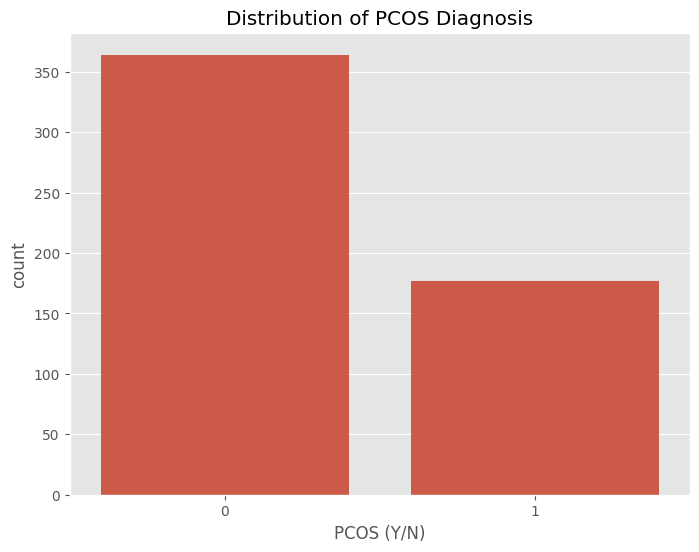

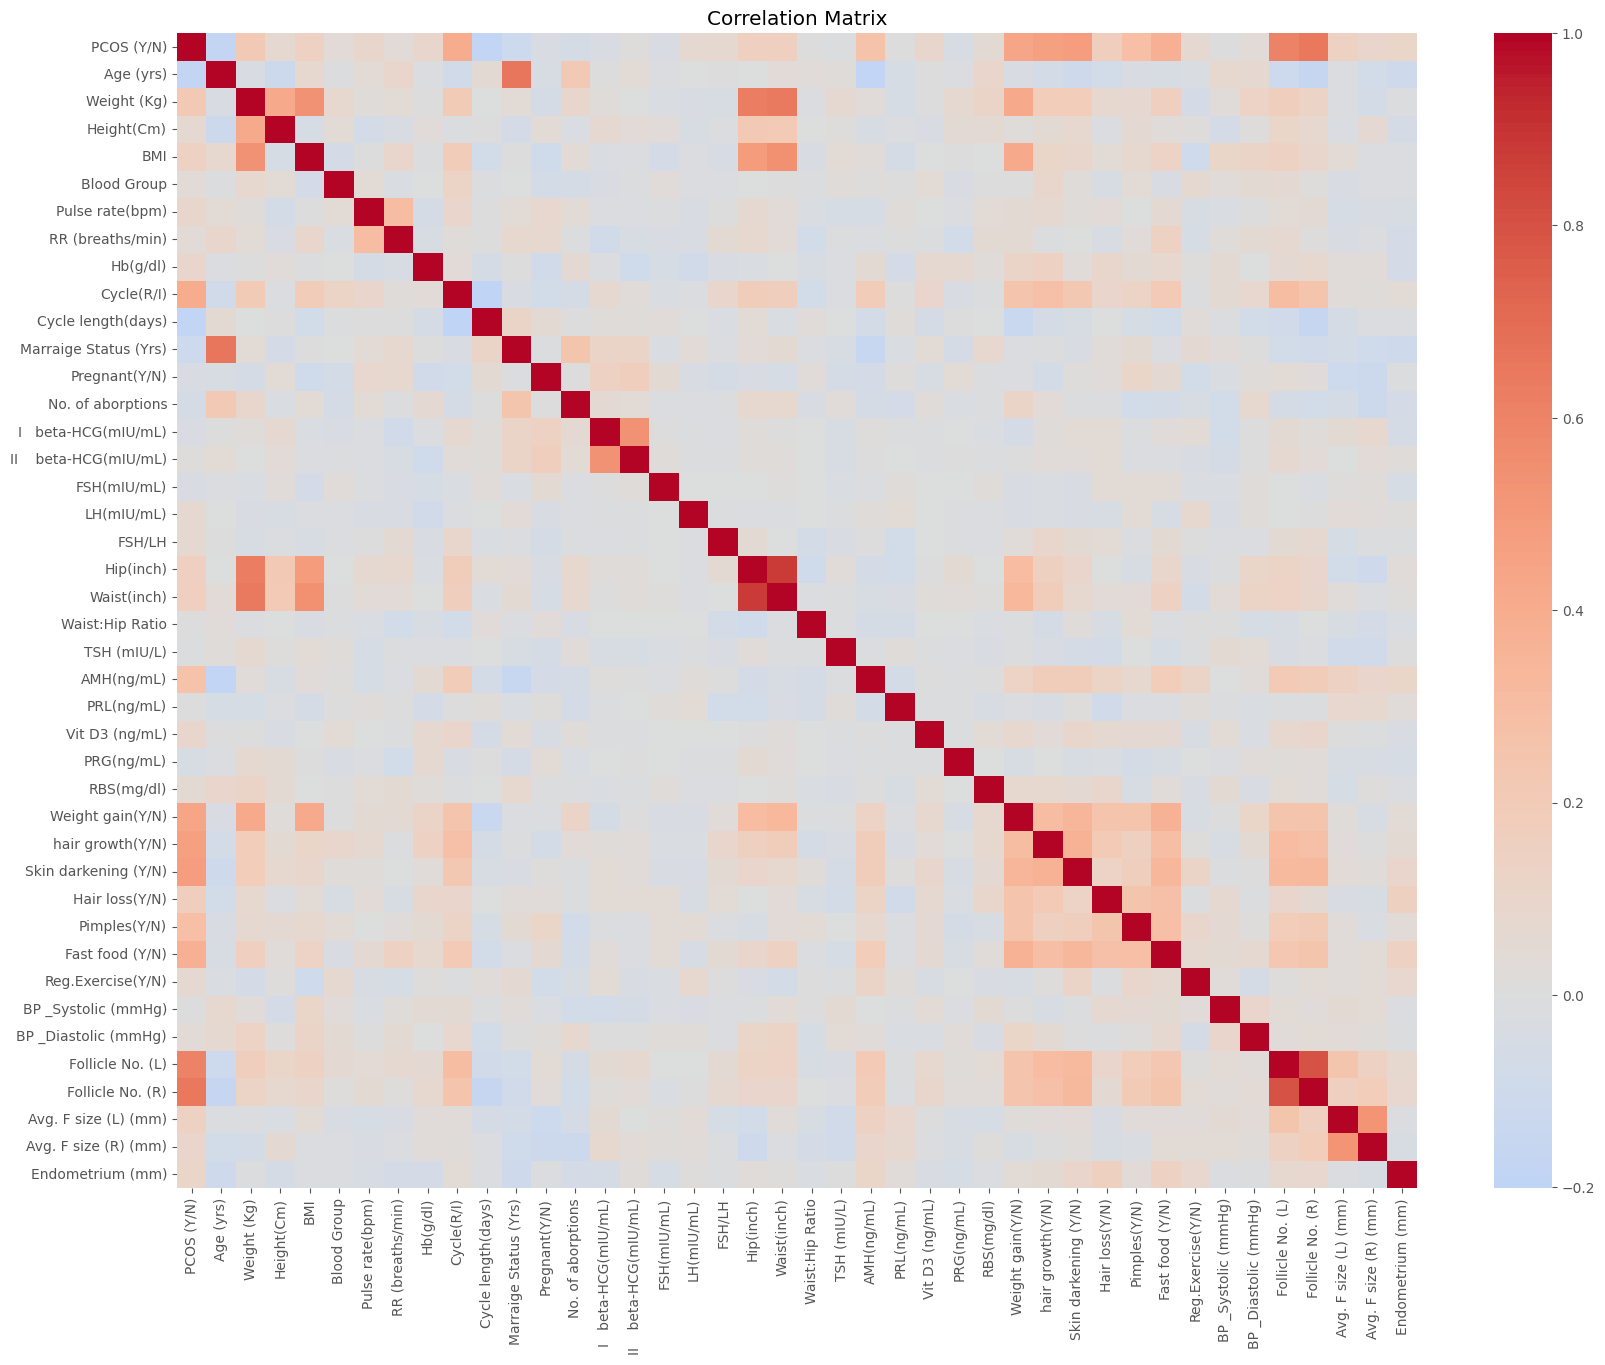


Top 10 Positive Correlations with PCOS:
Follicle No. (R)        0.648327
Follicle No. (L)        0.603346
Skin darkening (Y/N)    0.475733
hair growth(Y/N)        0.464667
Weight gain(Y/N)        0.441047
Cycle(R/I)              0.401644
Fast food (Y/N)         0.376183
Pimples(Y/N)            0.286077
AMH(ng/mL)              0.264141
Weight (Kg)             0.211938
Name: PCOS (Y/N), dtype: float64

Top 10 Negative Correlations with PCOS:
Cycle length(days)      -0.178480
Age (yrs)               -0.168513
Marraige Status (Yrs)   -0.113056
No. of aborptions       -0.057158
PRG(ng/mL)              -0.043834
FSH(mIU/mL)             -0.030319
I   beta-HCG(mIU/mL)    -0.027617
Pregnant(Y/N)           -0.027565
TSH (mIU/L)             -0.010140
Waist:Hip Ratio          0.002405
Name: PCOS (Y/N), dtype: float64


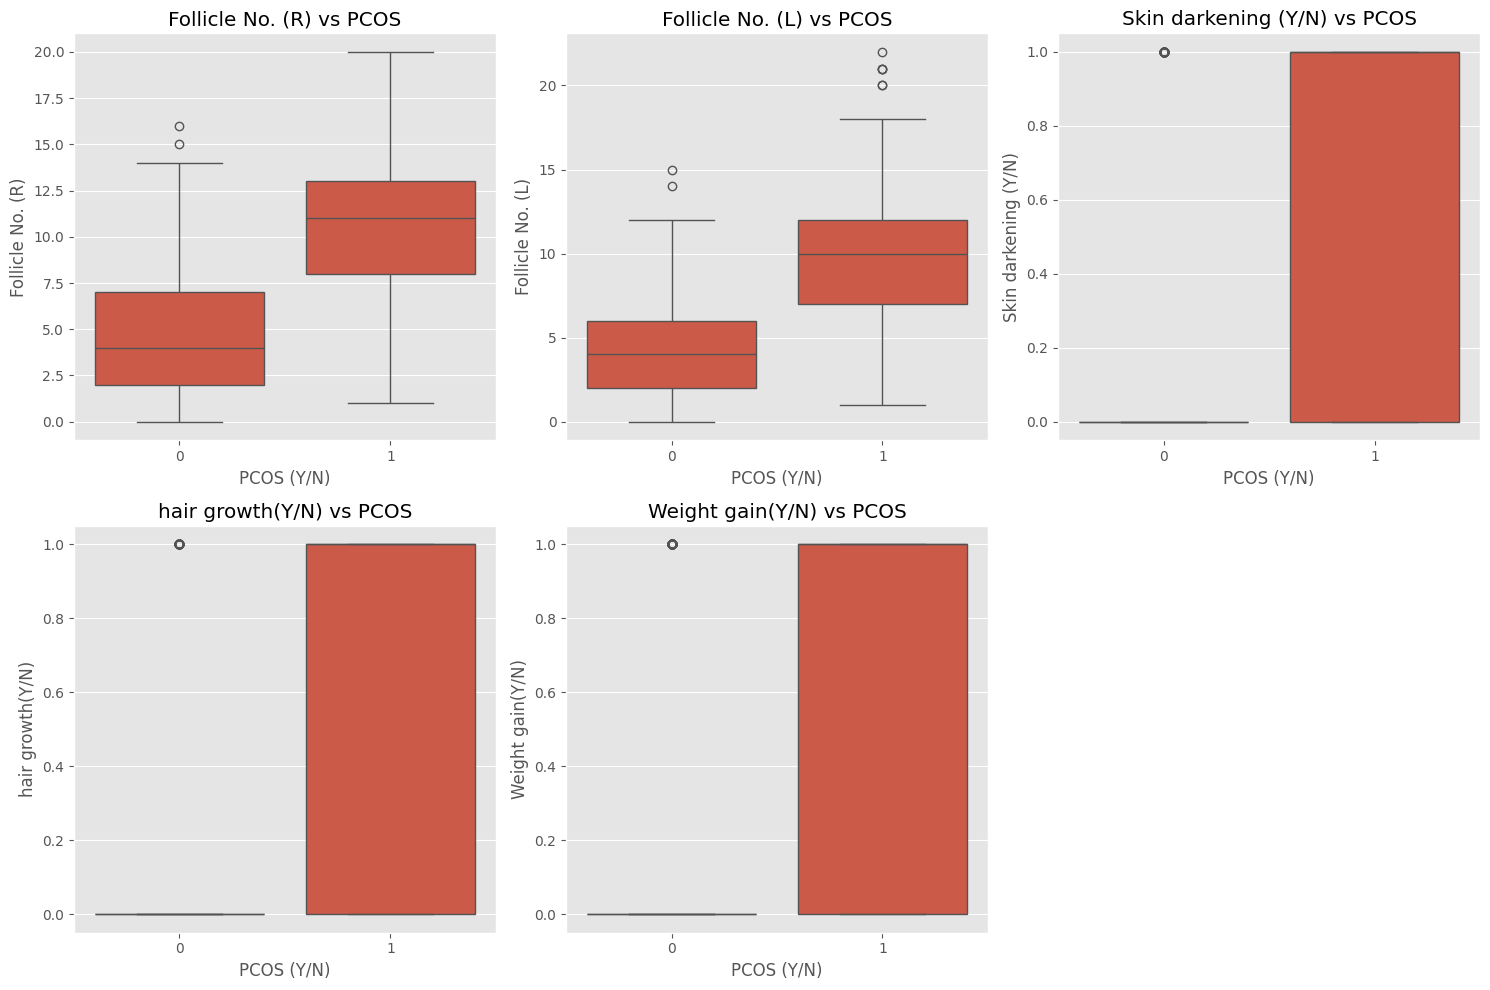

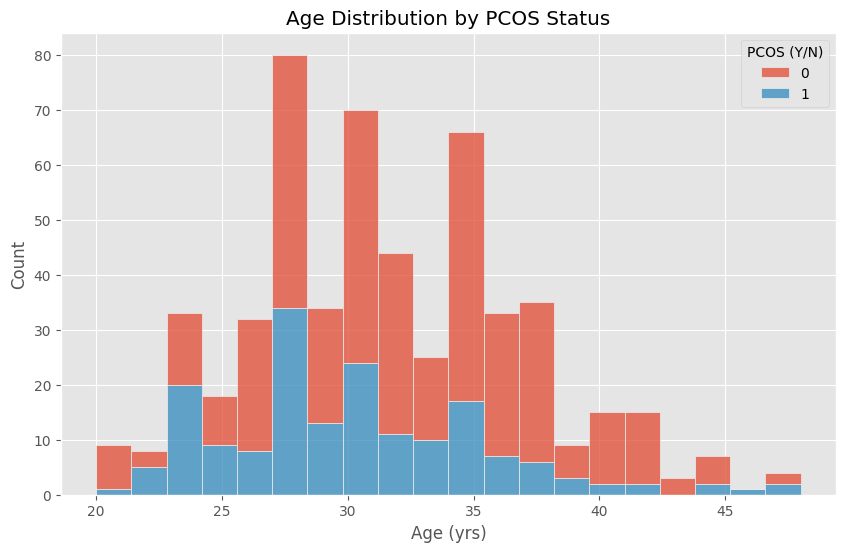

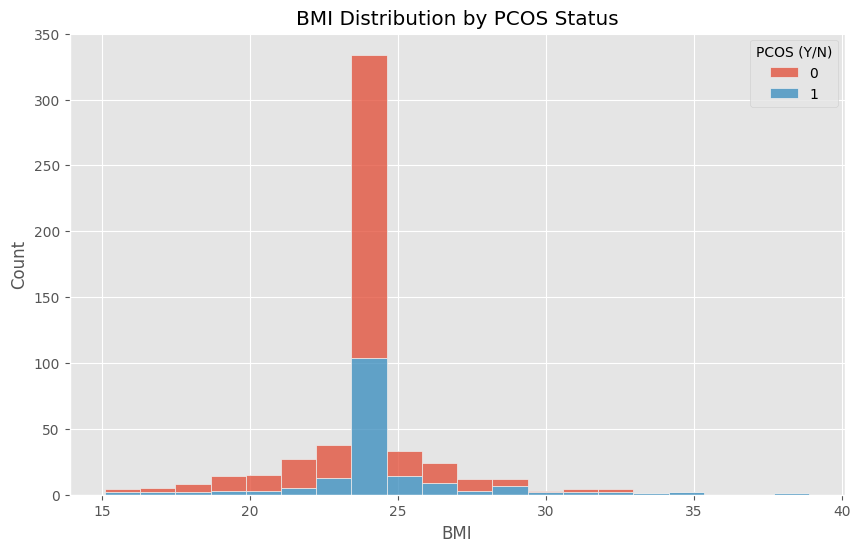

In [20]:
# Statistical summary
print("Statistical Summary:")
display(df2.describe())

# Target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='PCOS (Y/N)', data=df2)
plt.title('Distribution of PCOS Diagnosis')
plt.show()

# Correlation matrix
plt.figure(figsize=(20, 15))
corr = df2.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

# Top 10 features correlated with PCOS
top_features = corr['PCOS (Y/N)'].sort_values(ascending=False)[1:11]
print("\nTop 10 Positive Correlations with PCOS:")
print(top_features)

bottom_features = corr['PCOS (Y/N)'].sort_values()[:10]
print("\nTop 10 Negative Correlations with PCOS:")
print(bottom_features)

# Plot distributions of top correlated features
plt.figure(figsize=(15, 10))
for i, col in enumerate(top_features.index[:5]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='PCOS (Y/N)', y=col, data=df2)
    plt.title(f'{col} vs PCOS')
plt.tight_layout()
plt.show()

# Age distribution by PCOS status
plt.figure(figsize=(10, 6))
sns.histplot(data=df2, x='Age (yrs)', hue='PCOS (Y/N)', multiple='stack', bins=20)
plt.title('Age Distribution by PCOS Status')
plt.show()

# BMI distribution by PCOS status
plt.figure(figsize=(10, 6))
sns.histplot(data=df2, x='BMI', hue='PCOS (Y/N)', multiple='stack', bins=20)
plt.title('BMI Distribution by PCOS Status')
plt.show()

In [21]:
# Create new features that might be clinically relevant
df2['LH/FSH Ratio'] = df2['LH(mIU/mL)'] / df2['FSH(mIU/mL)']
df2['BMI Category'] = pd.cut(df2['BMI'], 
                            bins=[0, 18.5, 25, 30, 100], 
                            labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
df2['BMI Category'] = LabelEncoder().fit_transform(df2['BMI Category'])

# Check correlation of new features
new_features_corr = df2[['LH/FSH Ratio', 'BMI Category', 'PCOS (Y/N)']].corr()
print("Correlation of New Features with PCOS:")
print(new_features_corr['PCOS (Y/N)'])

# Select features based on correlation and domain knowledge
selected_features = [
    'Age (yrs)', 'Weight (Kg)', 'BMI', 'Cycle(R/I)', 'Cycle length(days)',
    'FSH(mIU/mL)', 'LH(mIU/mL)', 'LH/FSH Ratio', 'TSH (mIU/L)', 'AMH(ng/mL)',
    'PRL(ng/mL)', 'Vit D3 (ng/mL)', 'Weight gain(Y/N)', 'hair growth(Y/N)',
    'Skin darkening (Y/N)', 'Pimples(Y/N)', 'Follicle No. (L)', 'Follicle No. (R)',
    'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)'
]

X = df2[selected_features]
y = df2['PCOS (Y/N)']

# Check class balance
print("\nClass Distribution:")
print(y.value_counts(normalize=True))

Correlation of New Features with PCOS:
LH/FSH Ratio    0.064776
BMI Category    0.068763
PCOS (Y/N)      1.000000
Name: PCOS (Y/N), dtype: float64

Class Distribution:
PCOS (Y/N)
0    0.672828
1    0.327172
Name: proportion, dtype: float64


In [22]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())

Training set shape: (432, 21)
Test set shape: (109, 21)

Class distribution after SMOTE:
PCOS (Y/N)
0    291
1    291
Name: count, dtype: int64



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        73
           1       0.85      0.92      0.88        36

    accuracy                           0.92       109
   macro avg       0.90      0.92      0.91       109
weighted avg       0.92      0.92      0.92       109



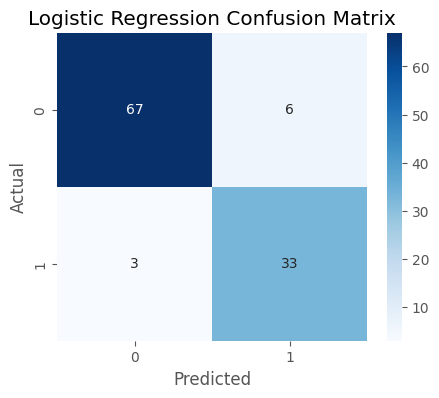

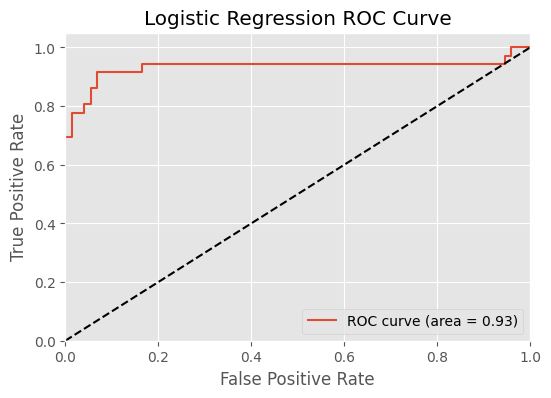


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        73
           1       0.91      0.83      0.87        36

    accuracy                           0.92       109
   macro avg       0.92      0.90      0.90       109
weighted avg       0.92      0.92      0.92       109



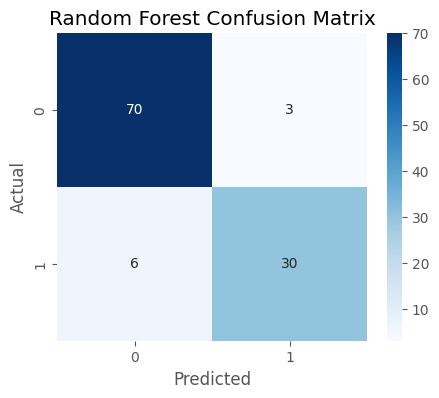

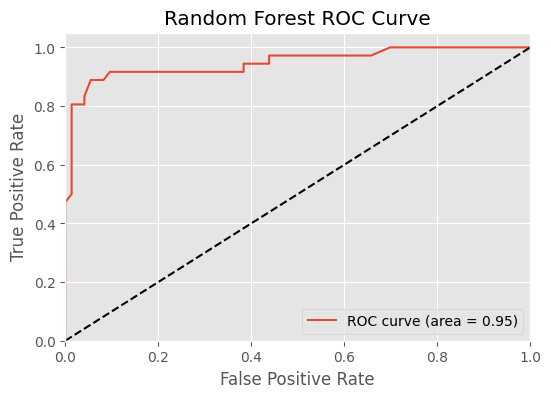


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        73
           1       0.91      0.81      0.85        36

    accuracy                           0.91       109
   macro avg       0.91      0.88      0.89       109
weighted avg       0.91      0.91      0.91       109



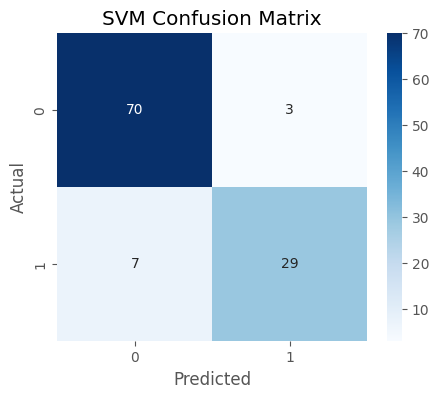

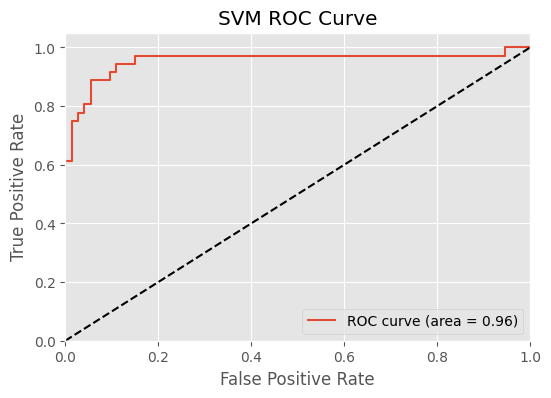


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95        73
           1       0.91      0.86      0.89        36

    accuracy                           0.93       109
   macro avg       0.92      0.91      0.92       109
weighted avg       0.93      0.93      0.93       109



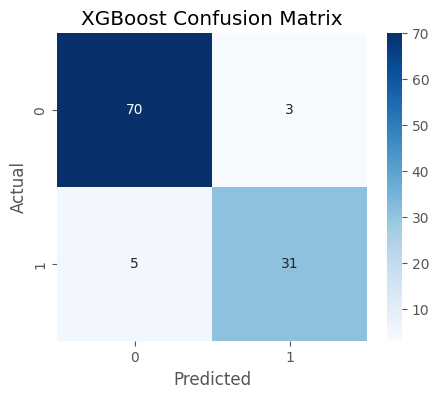

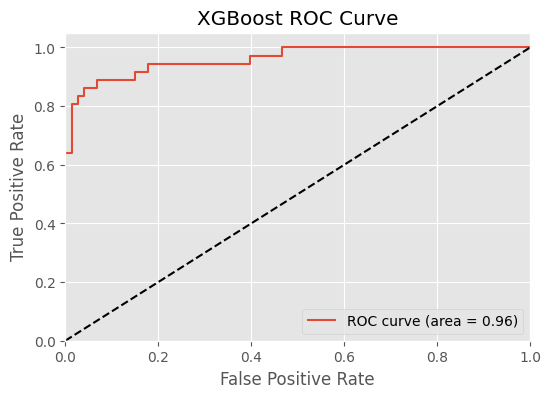

[LightGBM] [Info] Number of positive: 291, number of negative: 291
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 582, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

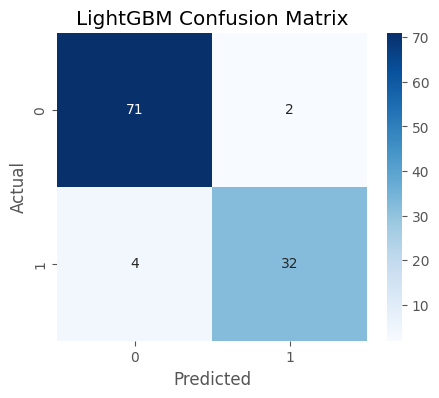

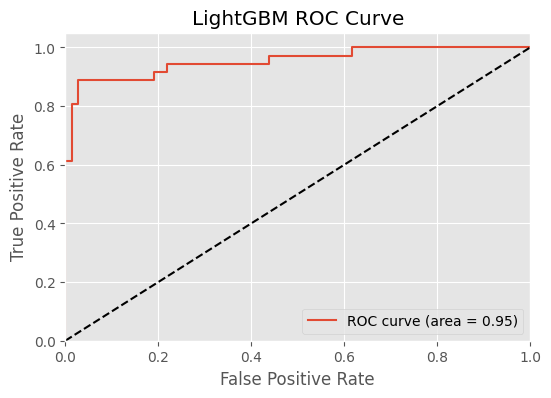


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        73
           1       0.94      0.89      0.91        36

    accuracy                           0.94       109
   macro avg       0.94      0.93      0.94       109
weighted avg       0.94      0.94      0.94       109



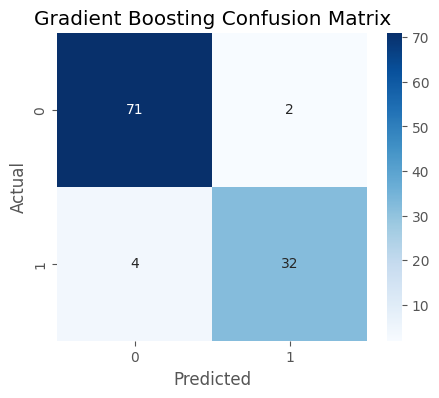

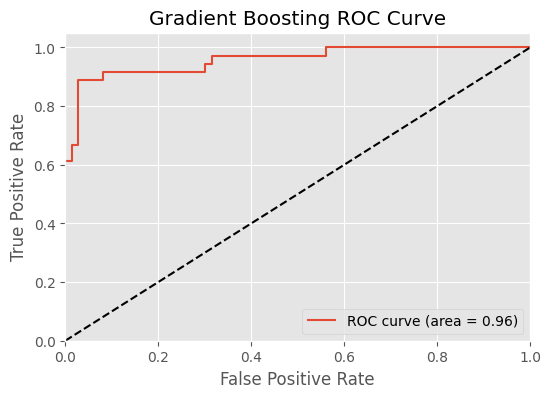


AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        73
           1       0.81      0.83      0.82        36

    accuracy                           0.88       109
   macro avg       0.86      0.87      0.87       109
weighted avg       0.88      0.88      0.88       109



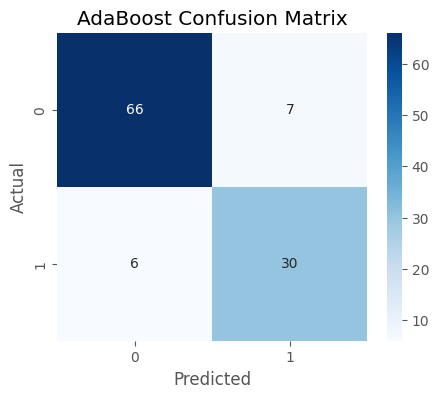

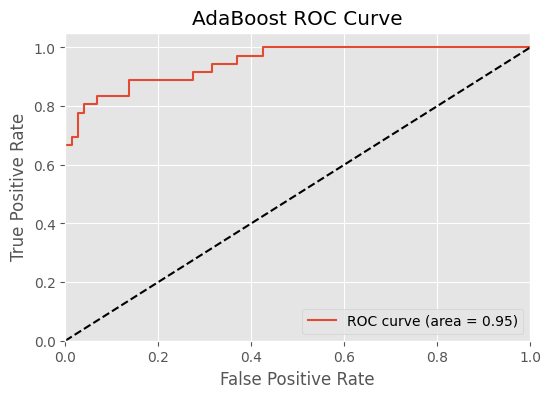


Model Performance Comparison:


,Accuracy,Precision,Recall,F1 Score,ROC AUC
XGBoost,0.926606,0.911765,0.861111,0.885714,0.960807
Gradient Boosting,0.944954,0.941176,0.888889,0.914286,0.958143
SVM,0.908257,0.906250,0.805556,0.852941,0.955479
LightGBM,0.944954,0.941176,0.888889,0.914286,0.954338
AdaBoost,0.880734,0.810811,0.833333,0.821918,0.948250
Random Forest,0.917431,0.909091,0.833333,0.869565,0.947679
Logistic Regression,0.917431,0.846154,0.916667,0.880000,0.933409


In [23]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }
    
    # Print classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Display results dataframe
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
display(results_df.sort_values(by='ROC AUC', ascending=False))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best ROC AUC score: 0.9805155283258429

Tuned XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        73
           1       0.91      0.83      0.87        36

    accuracy                           0.92       109
   macro avg       0.92      0.90      0.90       109
weighted avg       0.92      0.92      0.92       109


Tuned XGBoost ROC AUC: 0.9657534246575343


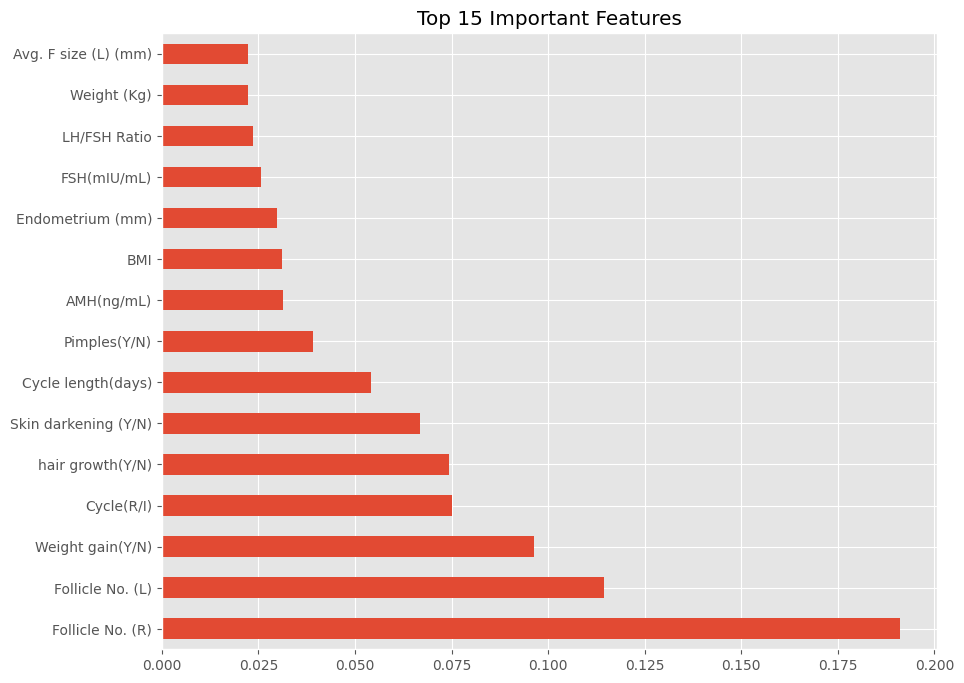

In [24]:
# Based on results, let's tune XGBoost
xgb = XGBClassifier(random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train_res, y_train_res)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best ROC AUC score:", grid_search.best_score_)

# Evaluate on test set
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test_scaled)
y_prob = best_xgb.predict_proba(X_test_scaled)[:, 1]

print("\nTuned XGBoost Classification Report:")
print(classification_report(y_test, y_pred))

print("\nTuned XGBoost ROC AUC:", roc_auc_score(y_test, y_prob))

# Plot feature importance
plt.figure(figsize=(10, 8))
feat_importances = pd.Series(best_xgb.feature_importances_, index=selected_features)
feat_importances.nlargest(15).plot(kind='barh')
plt.title('Top 15 Important Features')
plt.show()

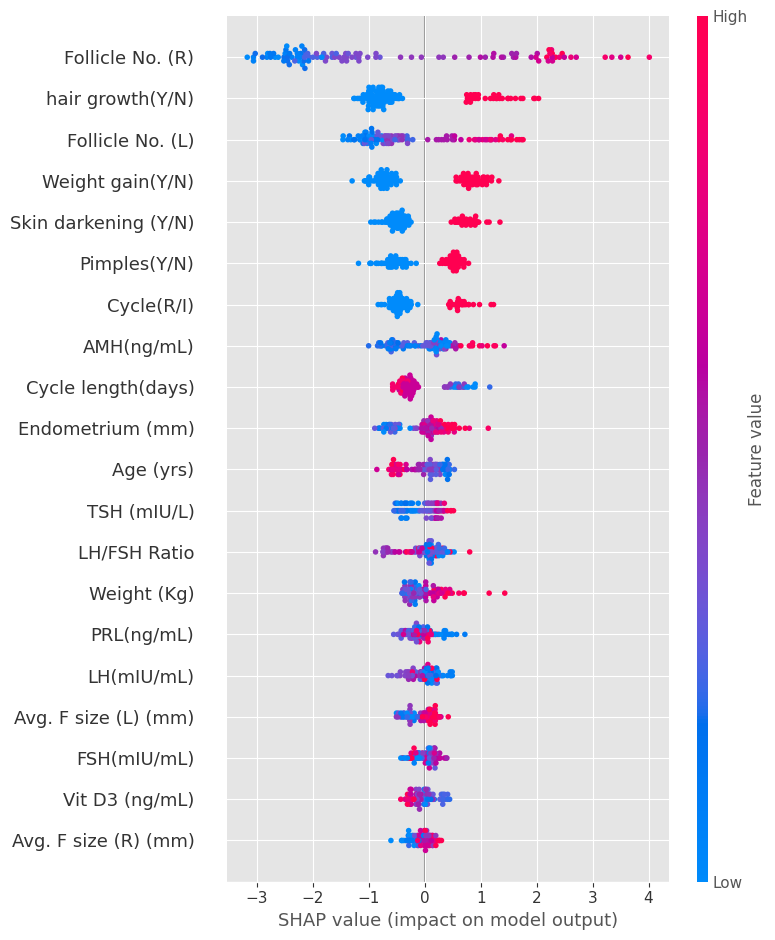

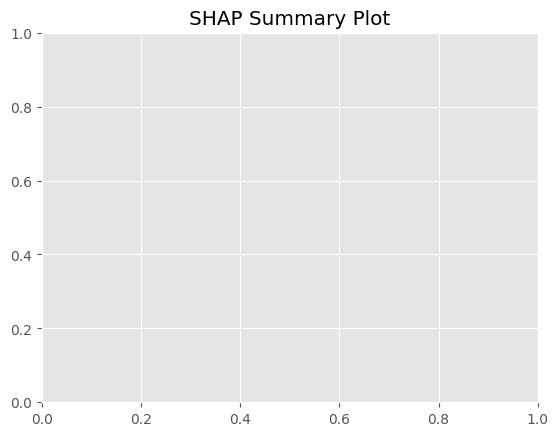

In [27]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test_scaled)

# Plot summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=selected_features)
plt.title('SHAP Summary Plot')
plt.show()

# Plot force plot for a specific instance
instance_idx = 0  # Change this to see different instances
shap.force_plot(
    explainer.expected_value, 
    shap_values[instance_idx], 
    X_test_scaled[instance_idx], 
    feature_names=selected_features
)

[LightGBM] [Info] Number of positive: 291, number of negative: 291
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 582, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

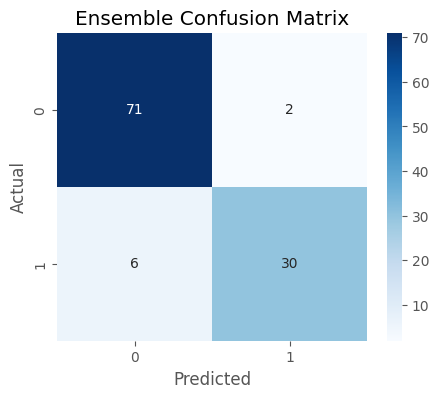

In [28]:
# Create ensemble of top performing models
ensemble = VotingClassifier(
    estimators=[
        ('xgb', XGBClassifier(**grid_search.best_params_, random_state=42)),
        ('lgbm', LGBMClassifier(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42))
    ],
    voting='soft'
)

# Train ensemble
ensemble.fit(X_train_res, y_train_res)

# Evaluate ensemble
y_pred = ensemble.predict(X_test_scaled)
y_prob = ensemble.predict_proba(X_test_scaled)[:, 1]

print("\nEnsemble Classification Report:")
print(classification_report(y_test, y_pred))

print("\nEnsemble ROC AUC:", roc_auc_score(y_test, y_prob))

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Ensemble Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [29]:
# Train final model on entire dataset (train + test)
X_scaled = scaler.fit_transform(X)
y_resampled = y.copy()  # We'll apply SMOTE to the entire dataset

# Apply SMOTE to the entire dataset
X_res, y_res = smote.fit_resample(X_scaled, y_resampled)

# Train the best model (XGBoost with tuned parameters) on all data
final_model = XGBClassifier(**grid_search.best_params_, random_state=42)
final_model.fit(X_res, y_res)

# Save the model and preprocessing objects
import joblib

joblib.dump(final_model, 'pcos_xgboost_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selected_features, 'selected_features.pkl')

print("Final model and preprocessing objects saved successfully.")

# Create a function for making predictions
def predict_pcos(new_data):
    """
    Predict PCOS probability for new data.
    
    Args:
        new_data (DataFrame): DataFrame containing the same features as training data
        
    Returns:
        tuple: (prediction, probability)
               prediction: 0 (No PCOS) or 1 (PCOS)
               probability: Probability of PCOS (between 0 and 1)
    """
    # Load saved objects
    model = joblib.load('pcos_xgboost_model.pkl')
    scaler = joblib.load('scaler.pkl')
    features = joblib.load('selected_features.pkl')
    
    # Preprocess new data
    new_data = new_data[features]
    new_data_scaled = scaler.transform(new_data)
    
    # Make prediction
    prob = model.predict_proba(new_data_scaled)[0, 1]
    pred = 1 if prob >= 0.5 else 0
    
    return pred, prob

# Example usage
example_data = pd.DataFrame([{
    'Age (yrs)': 25,
    'Weight (Kg)': 65,
    'BMI': 24,
    'Cycle(R/I)': 1,
    'Cycle length(days)': 35,
    'FSH(mIU/mL)': 5.2,
    'LH(mIU/mL)': 8.1,
    'LH/FSH Ratio': 8.1/5.2,
    'TSH (mIU/L)': 2.1,
    'AMH(ng/mL)': 6.5,
    'PRL(ng/mL)': 15,
    'Vit D3 (ng/mL)': 20,
    'Weight gain(Y/N)': 1,
    'hair growth(Y/N)': 1,
    'Skin darkening (Y/N)': 0,
    'Pimples(Y/N)': 1,
    'Follicle No. (L)': 12,
    'Follicle No. (R)': 10,
    'Avg. F size (L) (mm)': 5,
    'Avg. F size (R) (mm)': 6,
    'Endometrium (mm)': 8
}])

prediction, probability = predict_pcos(example_data)
print(f"\nExample Prediction: {'PCOS' if prediction == 1 else 'No PCOS'} (Probability: {probability:.2f})")

Final model and preprocessing objects saved successfully.

Example Prediction: PCOS (Probability: 0.99)
